# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:

    The data was organized by Sina Kashuk at CUSP. 
    It contains 23 different subway card types 
    (e.g. monthly pass, daily pass, Act for Disability pass…)

In [659]:
__author__ = "Le Xu, lx565"
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as pl
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale


%matplotlib inline

In [660]:
#load the data
mtarides = np.load('MTA_Fare.npy')

In [661]:
#check data shape
mtarides.shape

(600, 23, 194)

### the shape of the data: (600, 23, 194)
    600 is for # of stations
    23 is for 23 types of riderships
    194 is for 194 weeks

# First Step: Event detection
### Identify the most prominent event. 

In [662]:
# for now I have a series of timestamps
date = pd.date_range('05/21/2010','02/21/2014',freq = "W")
date

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-15', '2013-12-22', '2013-12-29', '2014-01-05',
               '2014-01-12', '2014-01-19', '2014-01-26', '2014-02-02',
               '2014-02-09', '2014-02-16'],
              dtype='datetime64[ns]', length=196, freq='W-SUN')

### The length of my timestampes is 196, which is not 194. My understanding is because the first week ends on '2010-05-30', the last week doesn't count becuase '2014-02-16' - '02/21/2014' counldnt count as a full week.

In [663]:
date = date[1:195]
date

DatetimeIndex(['2010-05-30', '2010-06-06', '2010-06-13', '2010-06-20',
               '2010-06-27', '2010-07-04', '2010-07-11', '2010-07-18',
               '2010-07-25', '2010-08-01',
               ...
               '2013-12-08', '2013-12-15', '2013-12-22', '2013-12-29',
               '2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [664]:
#23 ridetype
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [665]:
# flatten the data:
mtarides = mtarides.flatten()
mtarides = mtarides.astype(float)


In [666]:
# replace the -1 to nan
np.place(mtarides, mtarides < 0, np.nan)

In [667]:
#after replacement of -1 and nan, reshape the data
mtarides = mtarides.reshape(600, 23, 194)

In [668]:
# the sum of weekly rides
weekride = []
for i in range(194):
    weekride.append(np.nansum(mtarides[:,:,i]))

In [669]:
df1 = DataFrame({"week_ride" : weekride}, index = date)
df1.index.name = "week_startdate"
df1.index.astype(str)
df1.head()

,week_ride
week_startdate,
2010-05-30,26720267.0
2010-06-06,29265971.0
2010-06-13,29601189.0
2010-06-20,29387592.0
2010-06-27,29185768.0


### By binning these data, I have counts of weekly rides as a function of time. This data is on week level
----

## Let's visualized the data to get a sense of the data

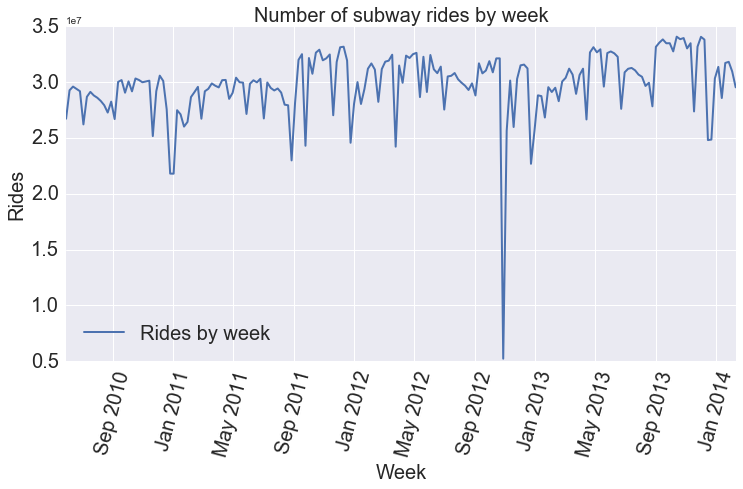

In [670]:
pl.figure(figsize=(12,6))
pl.plot(df1, lw = 2)
pl.xticks(rotation=75, fontsize=20)
pl.yticks(fontsize=20)
pl.xlabel("Week", fontsize=20)
pl.ylabel("Rides", fontsize=20)
pl.title("Number of subway rides by week",fontsize=20)
pl.legend(["Rides by week"], fontsize=20, loc = 3)

## The graph presented the relationship between datetime and numbers of rides. We can easily identify a steep gap between the datetime Sep 2012 and Jan 2013. 
----

### Set 3-sigma threshold
#### The mean and stardand deviation of the time series can be used to set a 3-sigma threshold

In [671]:
# mean:
mean = np.nanmean(df1.week_ride)
# std
std = np.nanstd(df1.week_ride)


In [672]:
print ("mean rides by week {:.2f}".format(mean))
print ("stdev rides by week {:.2f}".format(std))
thresholds = [mean + 3 * std, mean - 3 *std]
print ("3-sigma thresholds upper limit is\n{:.2f} \nand the lower limit is \n{:.2f}\n".format(*thresholds))



mean rides by week 29781349.87
stdev rides by week 2983960.42
3-sigma thresholds upper limit is
38733231.14 
and the lower limit is 
20829468.61



In [673]:
## Find out the index that exceeds the thresholds
ind = np.where((df1.week_ride > thresholds[0])|(df1.week_ride < thresholds[1]))
ind


(array([126]),)

In [674]:
df1.iloc[ind]

,week_ride
week_startdate,
2012-10-28,5218686.0


### The appeared date "2012-10-28" validates visualization becuase it is between the Sep 2012 and Jan 2013. The numbers of rides 5,218,686 is extreme low because the mean is 29,781,349. 
---

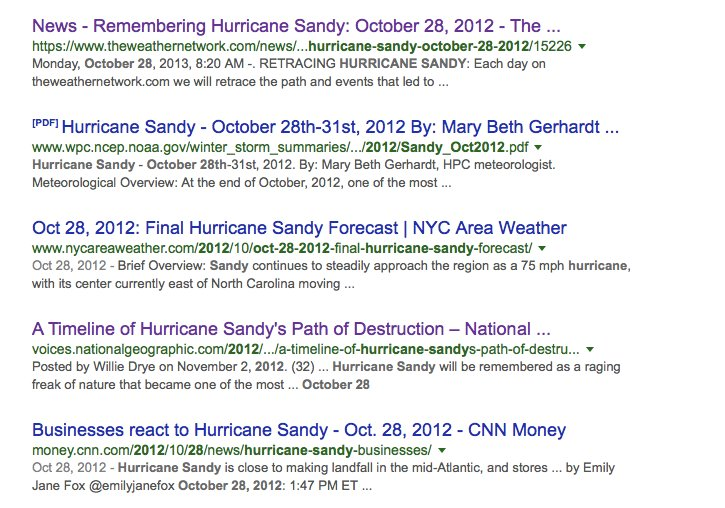

In [675]:
Image(filename = "SANDY-10_28.jpg")

### I believe the Hurricane Sandy is the main reason on the drop of subway rides for the week of 2012-10-28
---

# Second Step: Identify Trends from type of riderships

In [676]:
## WE need the data only with 194 weeks and 23 kinds of card type
riderships = np.nanmean(mtarides[:,:,:], axis=0) 
riderships.shape

(23, 194)

In [677]:
df2 = DataFrame(riderships)
df2 = df2.T
df4 = df2
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,24880.119048,1148.320346,103.465368,403.790043,101.316017,8003.123377,18510.686147,21.781385,721.205628,1108.294372,...,266.523810,1710.194805,129.456710,61.084416,0.00000,269.898268,45.584416,13.264069,0.774892,NaN
1,27173.229935,1265.798265,111.683297,432.167028,139.594360,8637.327549,20577.861171,25.698482,613.351410,1253.845987,...,329.605206,1969.778742,150.127983,70.136659,0.00000,264.019523,47.006508,13.275488,1.028200,NaN
2,27573.708423,1266.077754,111.524838,431.248380,123.097192,8710.647948,20467.684665,26.516199,652.328294,1329.453564,...,327.295896,1974.349892,150.267819,70.449244,0.00000,263.889849,46.291577,14.017279,1.004320,NaN
3,27329.751620,1215.123110,112.447084,424.166307,80.840173,8710.049676,20410.542117,24.235421,659.855292,1309.438445,...,317.697624,1949.349892,147.082073,69.987041,0.00000,263.609071,46.717063,14.233261,1.045356,NaN
4,27607.099138,1182.883621,110.243534,420.006466,75.883621,8460.012931,20030.176724,22.661638,723.663793,1214.323276,...,297.172414,1843.907328,143.053879,68.821121,0.37931,258.137931,43.743534,13.605603,0.974138,NaN


### we should drop the 2012-10-28 date 


In [678]:
df2.drop(126, inplace = True)


In [679]:
df2[1].head()  #just checking 

0    1148.320346
1    1265.798265
2    1266.077754
3    1215.123110
4    1182.883621
Name: 1, dtype: float64

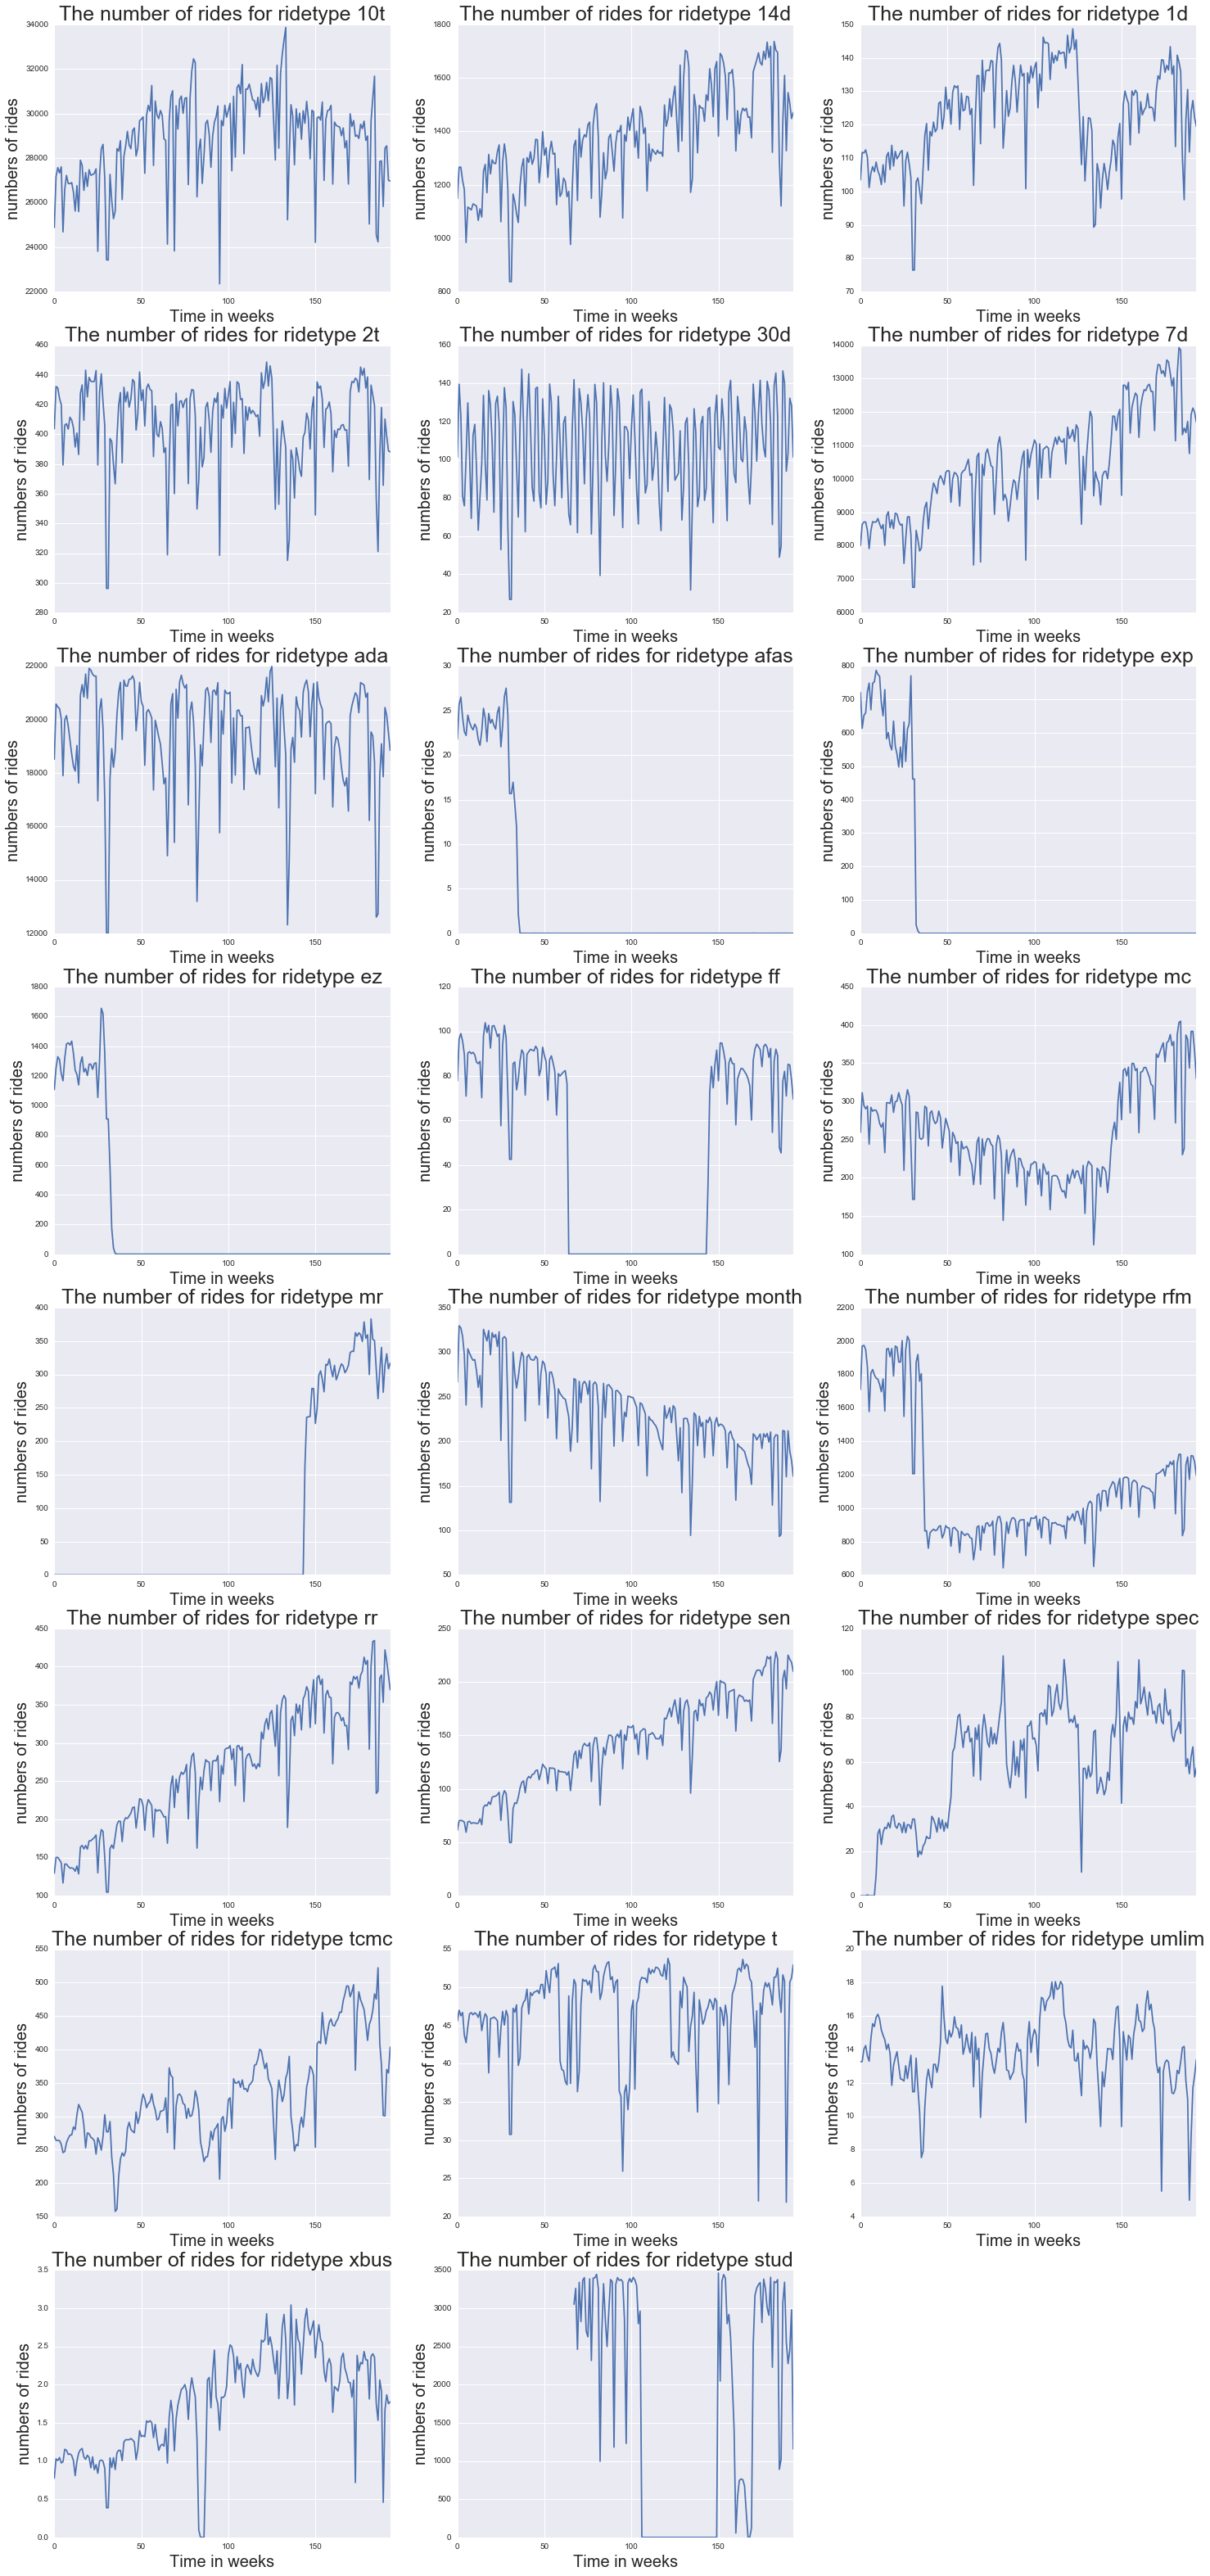

In [680]:
fig1 = pl.figure(figsize =(25,55))
for i in range(23):
    fig1.add_subplot(8,3, i+1)
    df2[i].plot()
    pl.title("The number of rides for ridetype " + ridetype[i], fontsize = 25)
    pl.xlabel("Time in weeks", fontsize = 20)
    pl.ylabel("numbers of rides", fontsize = 20)
    
    

## The group of 23 plots above is consist of plots of numbers of rides for 23 different types of subway cards. 
### We can individually examine them by just looking at those graphs. We can see 14d, 7d, rr, sen, tcmc have the most evident increase over the time. The month type is decreasing constantly. Also, 10t, 2t, 30d, ada and t seemed like stationary series.

---

## Smoothing: Use the algorithmic way to do 
1. log transformation 
2. by calculating the rolling mean


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


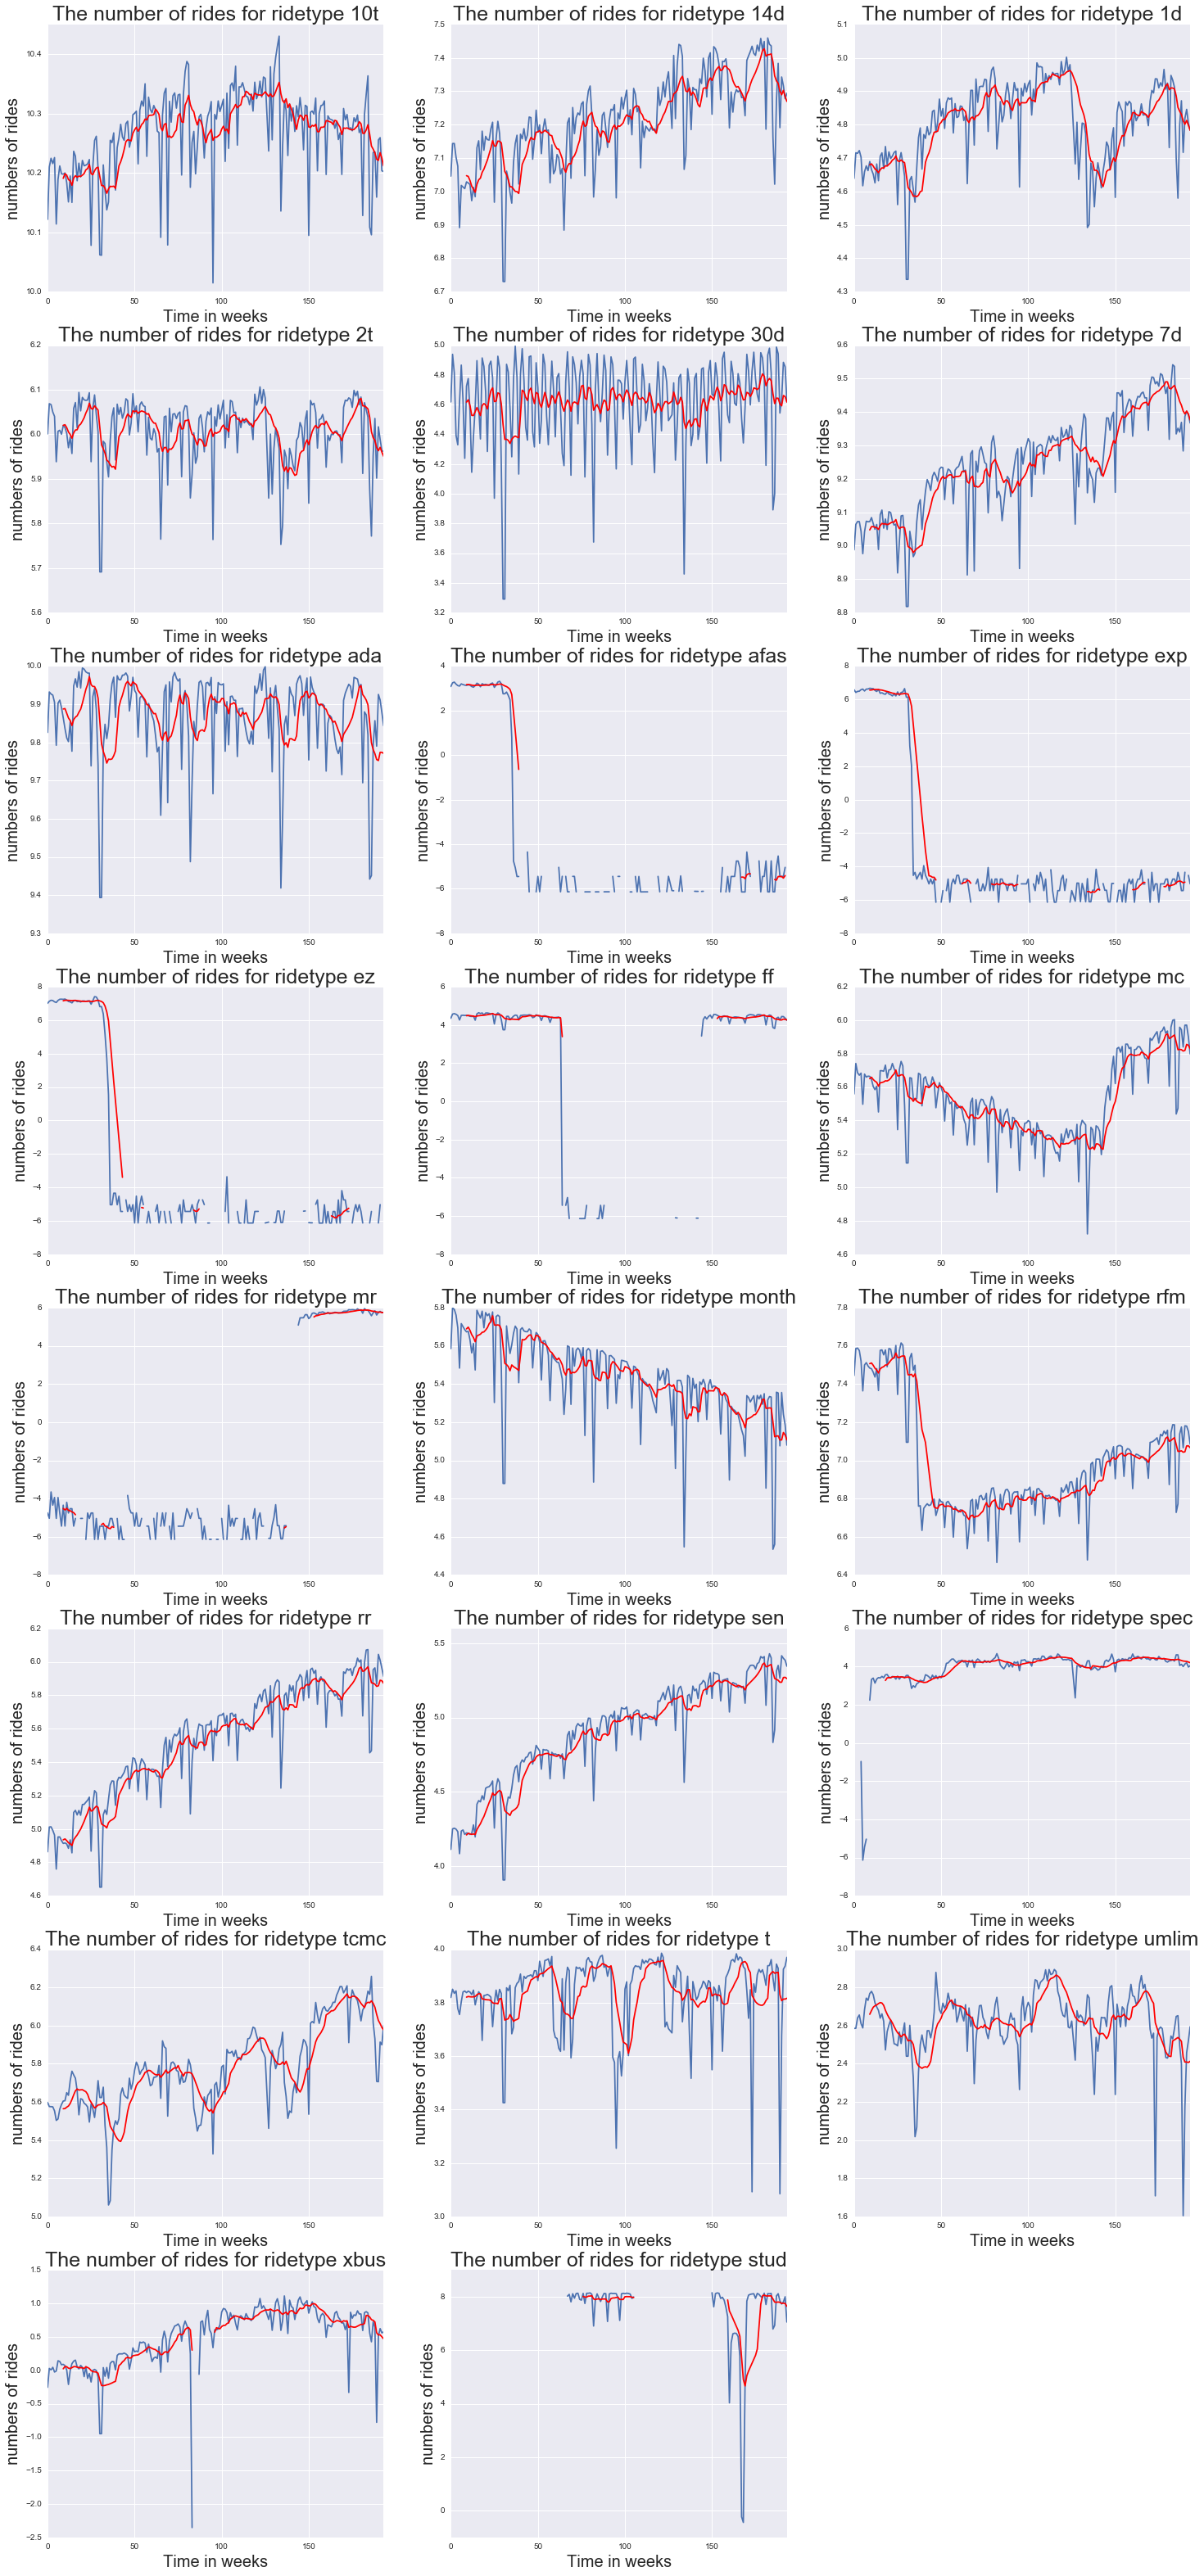

In [681]:
fig1 = pl.figure(figsize =(25,55))
for i in range(23):
    fig1.add_subplot(8,3, i+1)
    np.log(df2[i]).plot()
    rolmean = pd.rolling_mean(np.log(df2[i]), window=10)
    mean = pl.plot(rolmean, color='r', label='Rolling Mean')
    
    pl.title("The number of rides for ridetype " + ridetype[i], fontsize = 25)
    pl.xlabel("Time in weeks", fontsize = 20)
    pl.ylabel("numbers of rides", fontsize = 20)

## The log transformation was performed on y axis, and the red line shows the rolling mean. The smoothing helps us to better identify the trends. There are some breaking lines, which we couldnt fully present the trend of certain rideship type.

## So by looking at the roling mean, we have confirmed that 14d, 7d, rr, sen, tcmc are increasing trends again. More, Xbus, spec and tcmc are also could be regarded as increasing trends overall. The month type is the only constant decreasing trend here.

---

## Let's only study the ridetypes with the evident increase or decrease.


14d, 7d, rr, sen, tcmc have the most evident increase over the time. The month type is decreasing constantly.

In [682]:
#assign the colunms names to ridetype in order to choose the colunms based on names
df2.columns = ridetype


In [683]:
df2.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
0,24880.119048,1148.320346,103.465368,403.790043,101.316017,8003.123377,18510.686147,21.781385,721.205628,1108.294372,...,266.523810,1710.194805,129.456710,61.084416,0.00000,269.898268,45.584416,13.264069,0.774892,NaN
1,27173.229935,1265.798265,111.683297,432.167028,139.594360,8637.327549,20577.861171,25.698482,613.351410,1253.845987,...,329.605206,1969.778742,150.127983,70.136659,0.00000,264.019523,47.006508,13.275488,1.028200,NaN
2,27573.708423,1266.077754,111.524838,431.248380,123.097192,8710.647948,20467.684665,26.516199,652.328294,1329.453564,...,327.295896,1974.349892,150.267819,70.449244,0.00000,263.889849,46.291577,14.017279,1.004320,NaN
3,27329.751620,1215.123110,112.447084,424.166307,80.840173,8710.049676,20410.542117,24.235421,659.855292,1309.438445,...,317.697624,1949.349892,147.082073,69.987041,0.00000,263.609071,46.717063,14.233261,1.045356,NaN
4,27607.099138,1182.883621,110.243534,420.006466,75.883621,8460.012931,20030.176724,22.661638,723.663793,1214.323276,...,297.172414,1843.907328,143.053879,68.821121,0.37931,258.137931,43.743534,13.605603,0.974138,NaN


In [684]:
ridetype_new = np.array(['14d','7d','month','rr','sen','tcmc'])

In [685]:
df3 = df2.loc[:,('14d','7d','month','rr','sen','tcmc')]
df3.iloc[0:10]

,14d,7d,month,rr,sen,tcmc
0,1148.320346,8003.123377,266.523810,129.456710,61.084416,269.898268
1,1265.798265,8637.327549,329.605206,150.127983,70.136659,264.019523
2,1266.077754,8710.647948,327.295896,150.267819,70.449244,263.889849
3,1215.123110,8710.049676,317.697624,147.082073,69.987041,263.609071
4,1182.883621,8460.012931,297.172414,143.053879,68.821121,258.137931
5,984.213823,7911.758099,240.658747,116.704104,59.328294,245.570194
6,1116.782328,8444.189655,303.732759,141.454741,69.105603,247.420259
7,1111.281385,8719.158009,298.863636,141.452381,69.608225,260.374459
8,1106.246220,8705.652268,294.231102,138.371490,67.568035,266.907127
9,1128.658747,8709.157667,290.930886,136.082073,68.250540,271.747300


### Calculate the ratio of the number of rides near the beginning to the number of rides near the end of the time series, see how the rides changed over the 194 weeks.

In [686]:

for i in range(6):
    # get the mean for first ten and last ten 
    tenfirst = np.nanmean(df3.iloc[0:10,i])
    tenlast = np.nanmean(df3.iloc[-10:,i])
    
    ratio = (tenlast - tenfirst)/tenfirst
    print ("The ratio of numbers of %s ridertype change is %.2f%%"%(ridetype_new[i], ratio*100))
    
    


The ratio of numbers of 14d ridertype change is 25.37%
The ratio of numbers of 7d ridertype change is 39.16%
The ratio of numbers of month ridertype change is -42.05%
The ratio of numbers of rr ridertype change is 159.65%
The ratio of numbers of sen ridertype change is 191.33%
The ratio of numbers of tcmc ridertype change is 53.42%


### Use ADickey-Fuller test to test the stationarity:
#### It is clearly evident that there are some overall increasing/decreasing trends in the data along with some seasonal variations. However, it might not always be right to make such visual inferences. So, more formally, we can check stationarity using the following:

## $H0$ = There is a unit root, the series is not stationary 
## $HA$ = There is no unit root, the series is stationary 

$alpha$ = 0.05
### Other than p-value, if the test statistic of ADF test is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

In [687]:
df4.dropna(inplace = True)
for i in range(23):
    dftest = sm.tsa.adfuller(df4.iloc[:,i])
    if dftest[1] <0.05:
        print ("The p value of ridetype %s is %.4f, so it is stationary based on ADF test"%(ridetype[i],dftest[1]))
        

The p value of ridetype 2t is 0.0000, so it is stationary based on ADF test
The p value of ridetype 30d is 0.0195, so it is stationary based on ADF test
The p value of ridetype ada is 0.0000, so it is stationary based on ADF test
The p value of ridetype exp is 0.0000, so it is stationary based on ADF test
The p value of ridetype ez is 0.0000, so it is stationary based on ADF test
The p value of ridetype spec is 0.0085, so it is stationary based on ADF test
The p value of ridetype t is 0.0000, so it is stationary based on ADF test
The p value of ridetype umlim is 0.0000, so it is stationary based on ADF test
The p value of ridetype xbus is 0.0001, so it is stationary based on ADF test


## ADF test gave me the stationary series more than what we observed earlier. ADF includes 9 seriers, such as 2t, 30d, ada, exp, ez, spec, t, umlim, xbus.
### My observation for stationary series are 10t, 2t, 30d, ada and t . 


---

# 3.  Identify most prominent periodic trend for certain train station

In [688]:
df5 = np.nansum(mtarides, axis=1)
df5 = pd.DataFrame(df5.T)
df5.drop(126, inplace = True) #drop the sandy day
df5.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,160175.0,44849.0,5731.0,14242.0,16076.0,17412.0,11460.0,9809.0,9123.0,154914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,162641.0,41509.0,7032.0,17589.0,20283.0,20909.0,14094.0,11944.0,10923.0,157628.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


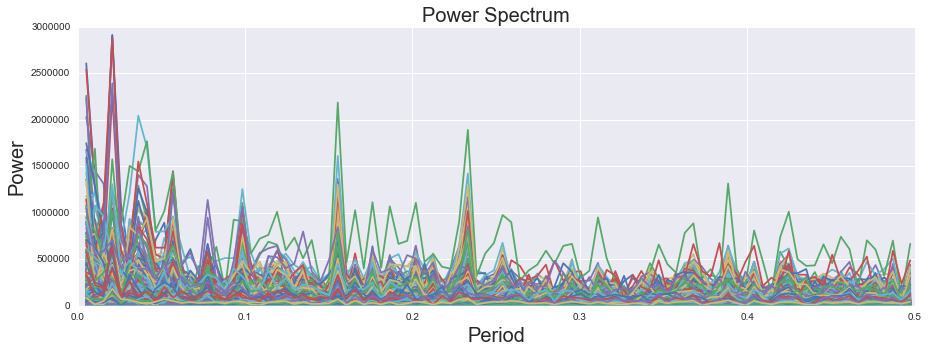

In [689]:
fig = pl.figure(figsize=(15,5))
period = []
peak = []
for i in range(600):
    ax=fig.add_subplot(111)
    a=np.abs(np.fft.rfft(df5.iloc[:,i], n = df5.iloc[:,i].size))[1:] #the FFT omitting its first value, 
    freq = np.fft.rfftfreq(df5.iloc[:,i].size, 1)[1:]
    #Period = 1/freq
    period.append(1/(freq[np.argmax(a)]))
    peak.append(a.max())
    
    pl.plot(freq,a)
    
#     pl.plot(np.fft.rfftfreq(N, 1.0/sample_rate), (f), '-')

pl.xlabel("Period", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Power Spectrum", fontsize=20)
    
    

## This is a "power spectrum": the plot of the absolute value of the fourier transform. This is to help visualize the 1-year period peak. 
---


(array([  62.,   23.,   40.,    8.,  166.,    0.,    0.,    0.,    0.,  301.]),
 array([   2.14444444,   21.23      ,   40.31555556,   59.40111111,
          78.48666667,   97.57222222,  116.65777778,  135.74333333,
         154.82888889,  173.91444444,  193.        ]),
 <a list of 10 Patch objects>)

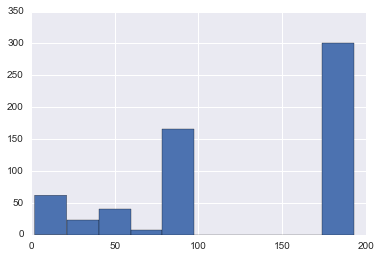

In [690]:
#Periodicity visulization
pl.hist(period) #just checking

## This histogram gives me an idea how the periodicity allocated, since there are total 194 weeks, so the tallest bar near 200 does not make any sense. Since the timestamps are set as week, so for one year period, we need to take close look for periodicity from 40-60

In [691]:
period = np.array(period)
per_new = period[period > 40]
per_new = per_new[per_new < 60]


In [692]:
stationid = np.where(period == 48.25)

In [693]:
stationid # stations that have 48.25 week periodicity

(array([  0,  13,  19,  32,  51,  54,  78,  96, 129, 146, 150, 163, 166,
        171, 186, 194, 280, 311, 327, 416, 417, 418, 420, 428, 454, 458,
        461, 462, 534, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 550]),)

In [694]:
newpeak = []
for i in stationid[0]: # the peak rides of the station's with 48.25 week periodicity
    newpeak.append(peak[i])
newpeak

[2912953.897227766,
 819814.38417579327,
 1576281.5728478169,
 2264829.9793669349,
 196417.24902878673,
 1047735.6514672342,
 475167.41355944535,
 337901.51460008597,
 78473.117761049667,
 365251.7455834056,
 2904568.2650655438,
 1025315.5414929811,
 510718.85946503771,
 602553.35554978799,
 460666.55503974156,
 2881003.3803480687,
 387116.22585961095,
 544958.79674405744,
 2392493.9043125669,
 153858.59146249518,
 53732.778362773613,
 200216.49951494462,
 57834.85695279151,
 176902.02940962522,
 29421.229981142209,
 161832.42234461795,
 651973.32339232508,
 704803.90629908268,
 417273.84749175399,
 1307599.2694160067,
 601251.50694241712,
 112146.79454826069,
 400926.58413755626,
 215434.81363426225,
 110363.47989737861,
 246620.93375147824,
 90887.8100347523,
 136624.05250692045,
 642463.56310123077,
 182914.94173966933]

In [695]:
lis = np.argsort(newpeak)

In [696]:
lis = lis[-8:] # top 8 highest power station by index
lis

array([ 5, 29,  2,  3, 18, 15, 10,  0])

In [697]:
newlis = []
for i in lis:
    print ("The station %d has %d rides and periodicity of 48.25 weeks"%(stationid[0][i],newpeak[i]))
    newlis.append(stationid[0][i])

The station 54 has 1047735 rides and periodicity of 48.25 weeks
The station 539 has 1307599 rides and periodicity of 48.25 weeks
The station 19 has 1576281 rides and periodicity of 48.25 weeks
The station 32 has 2264829 rides and periodicity of 48.25 weeks
The station 327 has 2392493 rides and periodicity of 48.25 weeks
The station 194 has 2881003 rides and periodicity of 48.25 weeks
The station 150 has 2904568 rides and periodicity of 48.25 weeks
The station 0 has 2912953 rides and periodicity of 48.25 weeks


## Currently we found top 8 stations with high power and periodicity of 48.25 weeks.


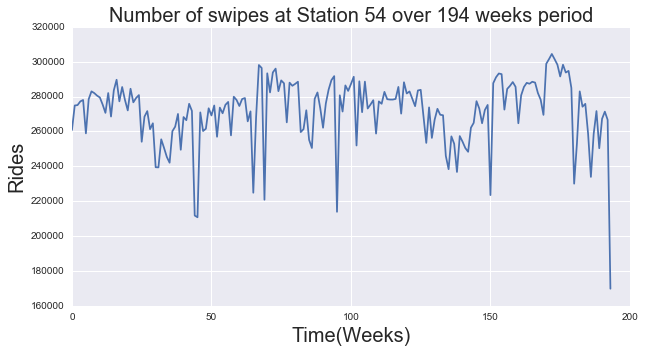

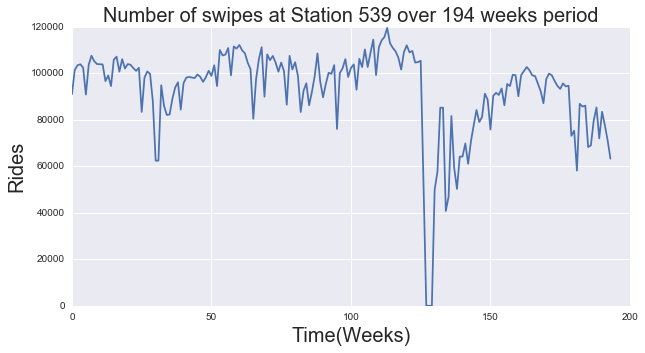

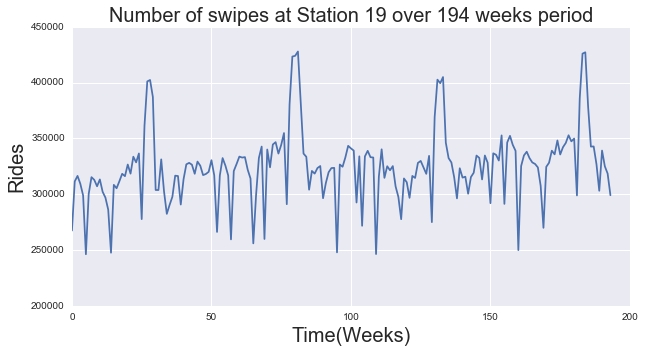

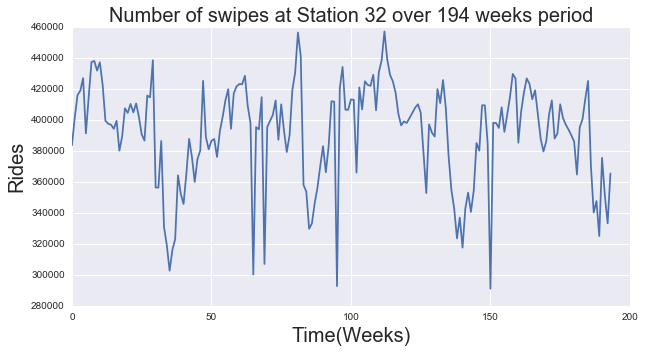

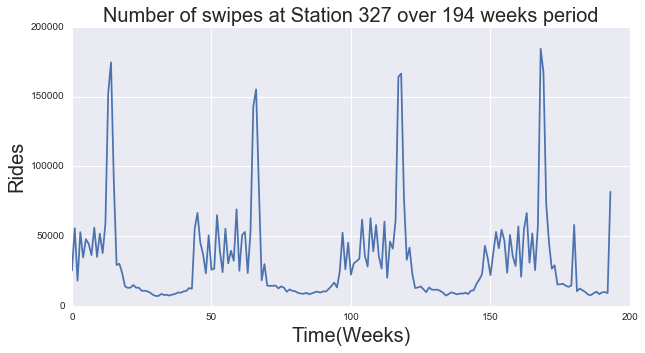

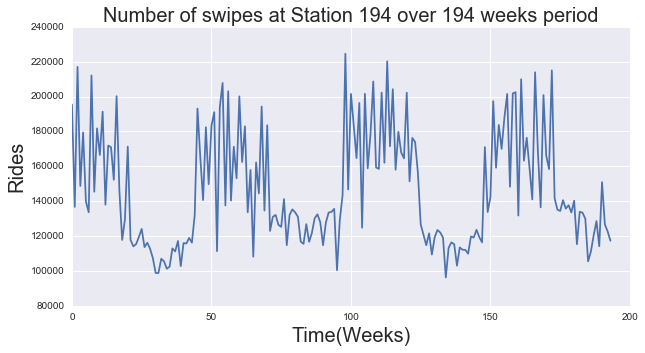

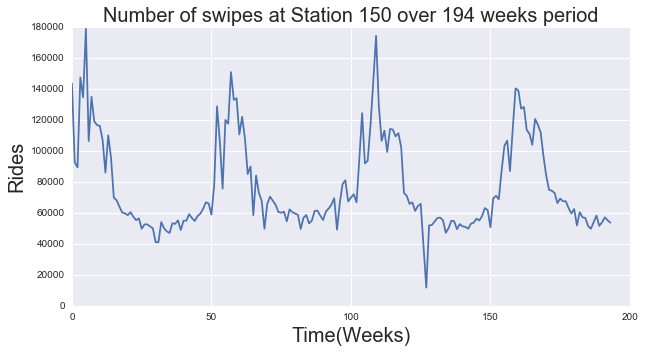

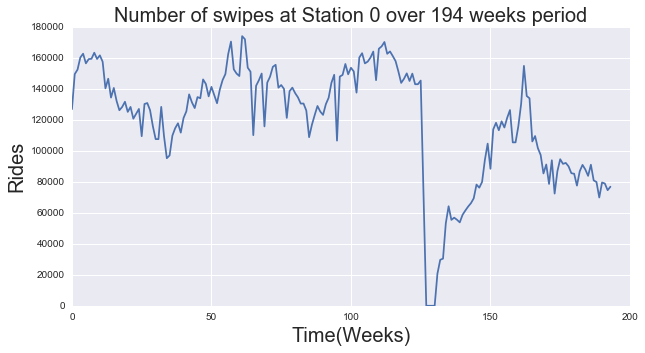

In [698]:
for i,j in enumerate(newlis):
    fig = pl.figure(figsize = (10,5))
    pl.plot(df5.iloc[:,j])
    pl.xlabel("Time(Weeks)", fontsize = 20)
    pl.ylabel("Rides", fontsize = 20)
    pl.title("Number of swipes at Station %d over 194 weeks period"%(newlis[i]), fontsize = 20)


## Above 8 graphs contain the numbers of swipes of different 8 station over 194 weeks period. We could easily identify the periodicity by looking at them. 
## From this visualization, station 19, 194, 327, 150 has the most evident periodity over this time period.
---------

# Thought: Why this periodicity occurs?

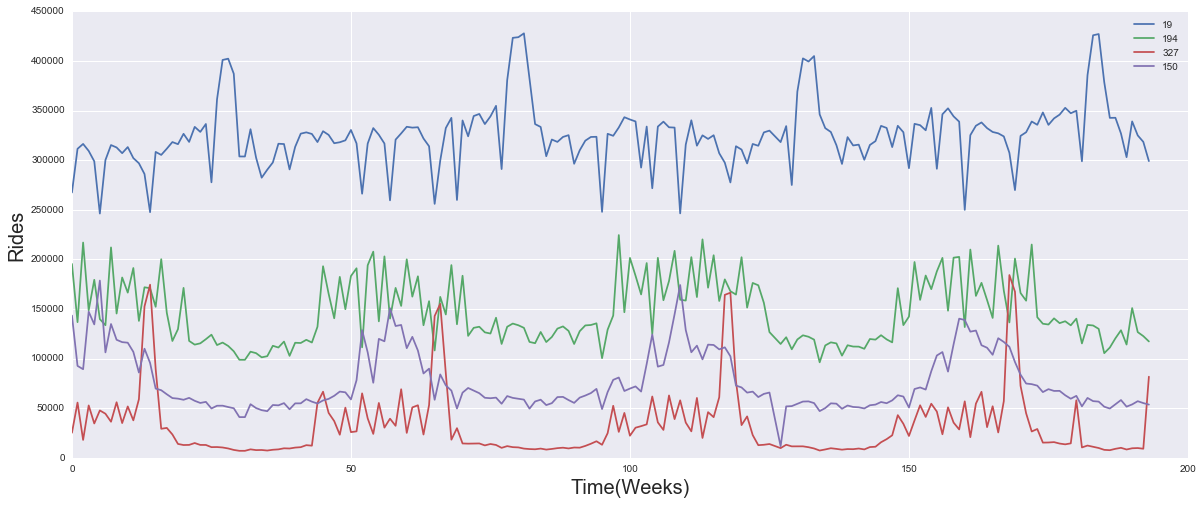

In [699]:
pl.figure(figsize = (20,8))
for i in (19,194,327,150):
    pl.plot(df5.iloc[:,i])
    pl.xlabel("Time(Weeks)", fontsize = 20)
    pl.ylabel("Rides", fontsize = 20)
    pl.legend(loc = 0)

## Since the location of station is not known, so we can look at the date for an idea of the behavior pattern. As the station 19 has different peak compare to other three stations, so we should analyze them separately into two teams.

In [700]:
# team 1 
date[48:70]

DatetimeIndex(['2011-05-01', '2011-05-08', '2011-05-15', '2011-05-22',
               '2011-05-29', '2011-06-05', '2011-06-12', '2011-06-19',
               '2011-06-26', '2011-07-03', '2011-07-10', '2011-07-17',
               '2011-07-24', '2011-07-31', '2011-08-07', '2011-08-14',
               '2011-08-21', '2011-08-28', '2011-09-04', '2011-09-11',
               '2011-09-18', '2011-09-25'],
              dtype='datetime64[ns]', name=u'week_startdate', freq='W-SUN')

### I believe, from the month May to Sep, which is the travel season and summer. Kid came back home, or visitors came to visit. Those stations in purple, red and green, could be around tourist attractions, such as time square or 34 st.


In [701]:
# team 2
date[25:30]

DatetimeIndex(['2010-11-21', '2010-11-28', '2010-12-05', '2010-12-12',
               '2010-12-19'],
              dtype='datetime64[ns]', name=u'week_startdate', freq='W-SUN')

### Since the peak are around winter time before christmas or after. I could guess this might be holiday shopping center? or even the place to See christmas tree!

## The further study needs further information.

# Extra credit:


In [702]:
tots = mtarides.transpose(2,0,1).reshape(mtarides.shape[2], mtarides.shape[1]*mtarides.shape[0]).T
tots.shape

(13800, 194)

In [703]:
tots = tots[tots.std(1)>0]
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
tots.shape

(7660, 194)

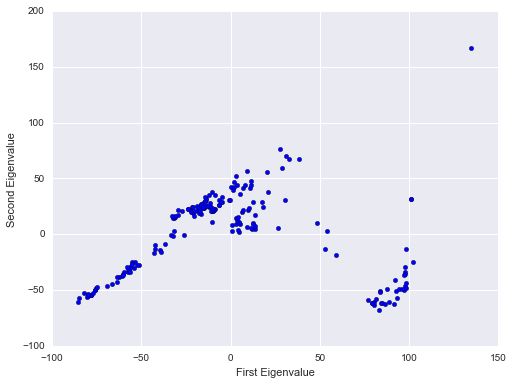

In [704]:
n=194
pca = PCA(n)
Xproj = pca.fit_transform(scale(vals.T))
pl.figure(2, figsize=(8, 6))
pl.clf()
pl.scatter(Xproj[:, 0], Xproj[:, 1])
pl.xlabel('First Eigenvalue')
pl.ylabel('Second Eigenvalue')

pl.show()

### Use silhouette_score to justify the optimal number k of clusters for K-means clustering

In [705]:
X = vals.T
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_clusters in range_n_clusters:
    km = cluster.KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(scale(X))
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.356576104666
For n_clusters =3, the average silhouette_score is :0.31362262773
For n_clusters =4, the average silhouette_score is :0.316945231046
For n_clusters =5, the average silhouette_score is :0.23181339054
For n_clusters =6, the average silhouette_score is :0.241072426402
For n_clusters =7, the average silhouette_score is :0.208778633143
For n_clusters =8, the average silhouette_score is :0.211933259043
For n_clusters =9, the average silhouette_score is :0.169465181306
For n_clusters =10, the average silhouette_score is :0.188855337763


### It seems like 2 , 4, 6 clusters could be good

In [706]:
n=2
KM=cluster.KMeans(n_clusters=n)
res_KM = KM.fit(scale(X))
print (res_KM.labels_)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]


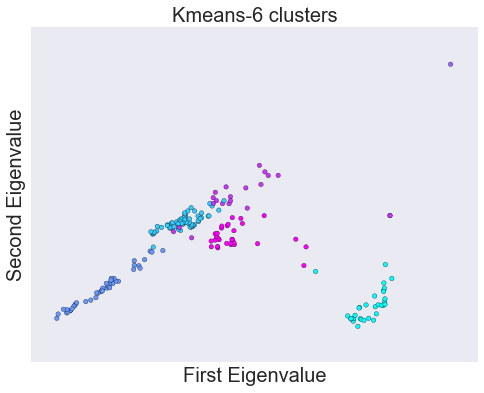

In [715]:
pl.figure(figsize = (8,6))
pl.scatter(Xproj[:, 0], Xproj[:, 1], c = res_KM.labels_, cmap=pl.cm.cool)
pl.xlabel('First Eigenvalue', fontsize = 20)
pl.ylabel('Second Eigenvalue', fontsize = 20)
pl.xticks(())
pl.yticks(())
pl.title("Kmeans-{} clusters".format(n),fontsize = 20)
pl.show()

## Above is the K-means with 2 clusters 

In [708]:
n=6
KM=cluster.KMeans(n_clusters=n)
res_KM = KM.fit(scale(X))
print (res_KM.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 0 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 5 4 4 4 1 1 4 1 1 1 1
 1 1 1 4 1 1 1 1 4 4 1 4 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 4 1 4 1 1 1 1 4 4 1 1 4 1 1 1 1 1 1 2 2 2
 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 4 4 2 2 2 2 2 2 2]


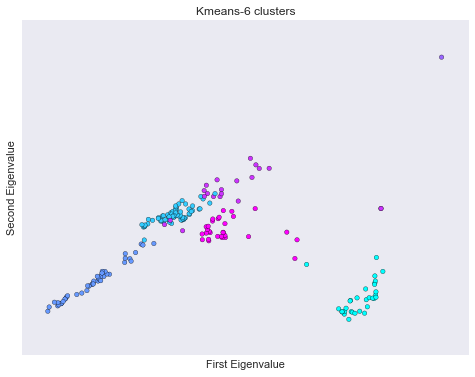

In [716]:
pl.figure(figsize = (8,6))
pl.scatter(Xproj[:, 0], Xproj[:, 1], c = res_KM.labels_, cmap=pl.cm.cool)
pl.xlabel('First Eigenvalue')
pl.ylabel('Second Eigenvalue')
pl.xticks(())
pl.yticks(())
pl.title("Kmeans-{} clusters".format(n))
pl.show()

## Above is the K-means with 6 clusters 
----

In [710]:
res = pd.DataFrame(res_KM.labels_)
res.columns = ["cluster"]
res.index = date
res.reset_index(inplace = True)


In [711]:
res.head()

,week_startdate,cluster
0,2010-05-30,0
1,2010-06-06,0
2,2010-06-13,0
3,2010-06-20,0
4,2010-06-27,0


In [712]:
res.week_startdate.groupby(res.cluster).count()

cluster
0    31
1    65
2    46
3     1
4    21
5    30
Name: week_startdate, dtype: int64